# DQAN (Deep Q-Adverserial Nets): DQN (Deep Q-Nets) + GAN (Gen. Adv. Nets)

In this notebook, we'll combine a DQN (deep Q-net) with GAN (generative adverserial net) that can learn to play games through reinforcement learning without any reward function. We'll call this network DQAN (deep Q adverserial net). 
Adverserial nets learn to maximize the current reward based the past rewards.
Q-net learns to maximize the future rewards based on the current reward.
Given a task and known when the task is done or failed, we should be able to learn the task.

# DQN
More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [38]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [39]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    print('state, action, reward, done, info')
    print(state, action, reward, done, info)
    if done:
        print('state, action, reward, done, info')
        print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

state, action, reward, done, info
[-0.02228548  0.1558804  -0.02325532 -0.31462795] 1 1.0 False {}
state, action, reward, done, info
[-0.01916787  0.35132577 -0.02954787 -0.61455318] 1 1.0 False {}
state, action, reward, done, info
[-0.01214136  0.54684786 -0.04183894 -0.91639411] 1 1.0 False {}
state, action, reward, done, info
[-1.20440153e-03  7.42509832e-01 -6.01668199e-02 -1.22192728e+00] 1 1.0 False {}
state, action, reward, done, info
[ 0.0136458   0.54821249 -0.08460537 -0.94868701] 0 1.0 False {}
state, action, reward, done, info
[ 0.02461004  0.74436533 -0.10357911 -1.26670816] 1 1.0 False {}
state, action, reward, done, info
[ 0.03949735  0.94064677 -0.12891327 -1.58995018] 1 1.0 False {}
state, action, reward, done, info
[ 0.05831029  0.74727    -0.16071227 -1.34008754] 0 1.0 False {}
state, action, reward, done, info
[ 0.07325569  0.94400833 -0.18751402 -1.67843843] 1 1.0 False {}
state, action, reward, done, info
[ 0.09213585  1.1407443  -0.22108279 -2.02317603] 1 1.0 Tru

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
1 0
2
1.0 1.0
1.1373282982386719 -1.7420916926362668


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [5]:
def model_input(state_size):
    # Given data
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Actions as output
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # Target Q values for training
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return states, next_states, actions, targetQs

In [6]:
# tf.layers.dense(
#     inputs, ????????????????????????
#     units, ??????????????????????
#     activation=None,
#     use_bias=True, OOOOOOOOOOOOOOOOOOOOOOOK
#     kernel_initializer=None,
#     bias_initializer=tf.zeros_initializer(), OOOOOOOOOOOOOOOK
#     kernel_regularizer=None,
#     bias_regularizer=None,
#     activity_regularizer=None,
#     kernel_constraint=None,
#     bias_constraint=None,
#     trainable=True, ??????????????????
#     name=None,
#     reuse=None
# )

In [20]:
# Q function
def generator(states, state_size, action_size, hidden_size, reuse=False, alpha=0.1): #training=True ~ batchnorm
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        #bn1 = tf.layers.batch_normalization(h1, training=training) #training=True ~ batchnorm
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        #bn2 = tf.layers.batch_normalization(h2, training=training) #training=True ~ batchnorm
        nl2 = tf.maximum(alpha * h2, h2)
        
        # # Output layer
        # logits_actions = tf.layers.dense(inputs=nl2, units=action_size, trainable=False)        
        # #predictions = tf.nn.softmax(logits_actions)

        # # Output layer
        # logits_next_states = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)        
        # #predictions = tf.nn.softmax(logits_next_states)

        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=(state_size + action_size))
        
        # Split the states and actions (opposite of fusion)
        logits_next_states, logits_actions = tf.split(value=logits, axis=1, num_or_size_splits=[state_size, action_size])

        return logits_actions, logits_next_states

In [21]:
# This is a reward function: Rt(St+1, at) or Rt(~St+1, ~at)
def discriminator(next_states, actions, hidden_size, reuse=False, alpha=0.1): #training=True ~ batchnorm
    with tf.variable_scope('discriminator', reuse=reuse):
        # Stack/concatenate/fuse actions and states or 
        # predicted/reconstructed actions and states
        x_fused = tf.concat(values=(next_states, actions), axis=1)
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        #bn1 = tf.layers.batch_normalization(h1, training=True)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        #bn2 = tf.layers.batch_normalization(h2, training=True)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)   
        #predictions = tf.sigmoid(logits)

        # logits for loss and reward/prob/out
        return logits

In [22]:
# Qt(St, At) = Rt(St+1, At) + max(alpha*Qt+1(St+1))
def model_loss(states, next_states, state_size, actions, action_size, hidden_size, targetQs, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param states: real current input states or observations given
    :param actions: real actions given
    :return: A tuple of (discriminator loss, generator loss)
    """
    # The fake/generated actions
    actions_logits, next_states_logits = generator(states=states, state_size=state_size, hidden_size=hidden_size, 
                                              action_size=action_size)
    #print(actions_logits.shape, next_states_logits.shape)
    actions_fake = tf.nn.softmax(actions_logits)
    next_states_fake = tf.sigmoid(x=next_states_logits)
    d_logits_fake = discriminator(next_states=next_states_fake, actions=actions_fake, hidden_size=hidden_size, reuse=False)

    # The real onehot encoded actions
    actions_real = tf.one_hot(actions, action_size)
    next_states_real = tf.sigmoid(x=next_states) 
    d_logits_real = discriminator(next_states=next_states_real, actions=actions_real, hidden_size=hidden_size, reuse=True)

    # Training the rewarding function
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    # Train the generate to maximize the current reward 0-1
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    # Train the generator to maximize the future rewards: Bellman equations: loss (targetQ - Q)^2
    Qs = tf.reduce_sum(tf.multiply(actions_logits, actions_real), axis=1)
    q_loss = tf.reduce_mean(tf.square(targetQs - Qs))

    # The generated rewards for Bellman equation
    rewards_fake = tf.sigmoid(d_logits_fake)
    rewards_real = tf.sigmoid(d_logits_real)

    return d_loss, g_loss, q_loss, actions_logits, Qs, rewards_fake, rewards_real

In [23]:
def model_opt(d_loss, g_loss, q_loss, learning_rate):
    """
    Get optimization operations
    :param d_loss: Discriminator/Reward loss Tensor for reward function
    :param g_loss: Generator/Q-value loss Tensor for action & next state predicton
    :param q_loss: Value loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=g_vars)

    return d_opt, g_opt, q_opt

In [24]:
class DQAN:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.next_states, self.actions, self.targetQs = model_input(state_size=state_size)
        #print(self.states, self.next_states, self.actions, self.targetQs)

        # Create the Model: calculating the loss and forwad pass
        self.d_loss, self.g_loss, self.q_loss, self.actions_logits, self.Qs, self.rewards_fake, self.rewards_real = model_loss(
            state_size=state_size, action_size=action_size, actions=self.actions, 
            states=self.states, next_states=self.next_states, 
            hidden_size=hidden_size, targetQs=self.targetQs)

        # Update the model: backward pass and backprop
        self.d_opt, self.g_opt, self.q_opt = model_opt(d_loss=self.d_loss, g_loss=self.g_loss, 
                                                       q_loss=self.q_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [25]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [26]:
train_episodes = 2000          # max number of episodes to learn from
max_steps = 200               # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64              # number of units in each Q-network hidden layer -- simulation
state_size = 4                # number of units for the input state/observation -- simulation
action_size = 2               # number of units for the output actions -- simulation

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 10                # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [27]:
tf.reset_default_graph()
model = DQAN(action_size=action_size, hidden_size=hidden_size, state_size=state_size, 
                 learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [28]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [29]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
d_loss_list, g_loss_list, q_loss_list = [], [], [] 
rewards_fake_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        d_loss, g_loss, q_loss = 0, 0, 0
        rewards_fake_mean = 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Average reward fake: {}'.format(rewards_fake_mean),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                rewards_fake_list.append((ep, rewards_fake_mean))
                d_loss_list.append((ep, d_loss))
                g_loss_list.append((ep, g_loss))
                q_loss_list.append((ep, q_loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train the model
            # feed_dict={model.states: next_states}
            # next_actions_logits, next_rewards_fake = sess.run([model.actions_logits, model.rewards_fake], feed_dict)
            feed_dict = {model.states: states}
            rewards_fake = sess.run(model.rewards_fake, feed_dict)
            feed_dict={model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)

            # Mean/average fake rewards or rewarded generated actions
            rewards_fake_mean = np.mean(rewards_fake.reshape(-1))
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            next_actions_logits[episode_ends] = (0, 0)

            # Bellman equation: Qt = Rt + max(Qt+1)
            targetQs = rewards_fake.reshape(-1) + (gamma * np.max(next_actions_logits, axis=1))
            # print('DEBUGGING', targetQs.shape, next_rewards_fake.shape, next_actions_logits.shape, np.max(next_actions_logits, axis=1).shape)

            # Updating the model
            # print(states.shape, next_states.shape, targetQs.shape, actions.shape)
            feed_dict = {model.states: states, model.next_states: next_states, model.actions: actions, model.targetQs: targetQs}
            #states, next_states, actions, Qs = sess.run([model.states, model.next_states, model.actions, model.Qs], feed_dict)
            #print(states.shape, next_states.shape, actions.shape, Qs.shape)
            #rewards_real = sess.run(model.rewards_real, feed_dict)
            #d_loss = sess.run(model.d_loss, feed_dict)
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
            
    # Save the trained model 
    saver.save(sess, 'checkpoints/DQAN-cartpole.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 4.0 Average reward fake: 0.49600401520729065 Training d_loss: 1.3503 Training g_loss: 0.7040 Training q_loss: 0.3883 Explore P: 0.9996
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 12.0 Average reward fake: 0.4843626022338867 Training d_loss: 1.3258 Training g_loss: 0.7298 Training q_loss: 1.3079 Explore P: 0.9984
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 15.0 Average reward fake: 0.46419015526771545 Training d_loss: 1.2461 Training g_loss: 0.7714 Training q_loss: 1.0862 Explore P: 0.9969
-------------------------------------------------------------------------------
---------------------------------------

-------------------------------------------------------------------------------
Episode: 26 Total reward: 17.0 Average reward fake: 0.0027573187835514545 Training d_loss: 0.0070 Training g_loss: 5.9505 Training q_loss: 2274.9844 Explore P: 0.9568
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 27 Total reward: 23.0 Average reward fake: 0.0025882641784846783 Training d_loss: 0.0061 Training g_loss: 5.9782 Training q_loss: 74.7151 Explore P: 0.9546
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 28 Total reward: 29.0 Average reward fake: 0.0019287423929199576 Training d_loss: 0.0043 Training g_loss: 6.2663 Training q_loss: 752.1080 Explore P: 0.9519
-------------------------------------------------------------------------------
----------------------

-------------------------------------------------------------------------------
Episode: 52 Total reward: 18.0 Average reward fake: 0.177458718419075 Training d_loss: 0.3636 Training g_loss: 5.9072 Training q_loss: 94.3858 Explore P: 0.9072
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 53 Total reward: 22.0 Average reward fake: 0.01383630745112896 Training d_loss: 0.0194 Training g_loss: 4.9600 Training q_loss: 233.3088 Explore P: 0.9053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 54 Total reward: 17.0 Average reward fake: 0.30263373255729675 Training d_loss: 1.0170 Training g_loss: 3.2420 Training q_loss: 269.2721 Explore P: 0.9037
-------------------------------------------------------------------------------
-------------------------------

-------------------------------------------------------------------------------
Episode: 78 Total reward: 29.0 Average reward fake: 0.00048787397099658847 Training d_loss: 0.0012 Training g_loss: 7.6280 Training q_loss: 28.3963 Explore P: 0.8641
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 79 Total reward: 10.0 Average reward fake: 0.0004745492187794298 Training d_loss: 0.0012 Training g_loss: 7.6556 Training q_loss: 17.0482 Explore P: 0.8633
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 80 Total reward: 17.0 Average reward fake: 0.00045774030149914324 Training d_loss: 0.0012 Training g_loss: 7.6916 Training q_loss: 26.6852 Explore P: 0.8618
-------------------------------------------------------------------------------
-----------------------

-------------------------------------------------------------------------------
Episode: 104 Total reward: 19.0 Average reward fake: 0.10555016994476318 Training d_loss: 0.4053 Training g_loss: 3.3421 Training q_loss: 339.7733 Explore P: 0.8222
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 105 Total reward: 11.0 Average reward fake: 0.06084895879030228 Training d_loss: 0.4291 Training g_loss: 3.0280 Training q_loss: 795.6295 Explore P: 0.8214
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 106 Total reward: 27.0 Average reward fake: 0.23606720566749573 Training d_loss: 0.9029 Training g_loss: 2.4916 Training q_loss: 26.1238 Explore P: 0.8192
-------------------------------------------------------------------------------
--------------------------

-------------------------------------------------------------------------------
Episode: 130 Total reward: 27.0 Average reward fake: 0.0010541107039898634 Training d_loss: 0.0031 Training g_loss: 6.8692 Training q_loss: 88.8581 Explore P: 0.7755
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 131 Total reward: 41.0 Average reward fake: 0.0009335441282019019 Training d_loss: 0.0029 Training g_loss: 6.9905 Training q_loss: 11.7241 Explore P: 0.7723
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 132 Total reward: 20.0 Average reward fake: 0.0007496114121749997 Training d_loss: 0.0023 Training g_loss: 7.2181 Training q_loss: 185.0631 Explore P: 0.7708
-------------------------------------------------------------------------------
---------------------

-------------------------------------------------------------------------------
Episode: 156 Total reward: 61.0 Average reward fake: 0.00018962589092552662 Training d_loss: 0.0005 Training g_loss: 8.5756 Training q_loss: 16.2658 Explore P: 0.7058
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 157 Total reward: 33.0 Average reward fake: 0.0001592159242136404 Training d_loss: 0.0004 Training g_loss: 8.7896 Training q_loss: 70.1717 Explore P: 0.7035
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 158 Total reward: 54.0 Average reward fake: 0.0002681927871890366 Training d_loss: 0.0004 Training g_loss: 8.2422 Training q_loss: 501.6870 Explore P: 0.6998
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 182 Total reward: 23.0 Average reward fake: 0.00013170877355150878 Training d_loss: 0.0002 Training g_loss: 8.9569 Training q_loss: 25.3423 Explore P: 0.6302
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 183 Total reward: 66.0 Average reward fake: 7.251829811139032e-05 Training d_loss: 0.0001 Training g_loss: 9.5399 Training q_loss: 1344.6448 Explore P: 0.6261
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 184 Total reward: 78.0 Average reward fake: 4.701294164988212e-05 Training d_loss: 0.0001 Training g_loss: 10.0480 Training q_loss: 24.3519 Explore P: 0.6213
-------------------------------------------------------------------------------
------------------

-------------------------------------------------------------------------------
Episode: 208 Total reward: 83.0 Average reward fake: 3.745673893718049e-05 Training d_loss: 0.0001 Training g_loss: 10.2323 Training q_loss: 57.9655 Explore P: 0.5600
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 209 Total reward: 101.0 Average reward fake: 2.694232898647897e-05 Training d_loss: 0.0000 Training g_loss: 10.5446 Training q_loss: 81.4375 Explore P: 0.5545
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 210 Total reward: 119.0 Average reward fake: 0.00026668544160202146 Training d_loss: 0.0003 Training g_loss: 8.2922 Training q_loss: 79.6108 Explore P: 0.5481
-------------------------------------------------------------------------------
-----------------

-------------------------------------------------------------------------------
Episode: 233 Total reward: 92.0 Average reward fake: 1.0952117918350268e-05 Training d_loss: 0.0000 Training g_loss: 11.4995 Training q_loss: 85.2137 Explore P: 0.4765
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 234 Total reward: 37.0 Average reward fake: 9.360000149172265e-06 Training d_loss: 0.0000 Training g_loss: 11.5934 Training q_loss: 139.0699 Explore P: 0.4748
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 235 Total reward: 108.0 Average reward fake: 9.349928404844832e-06 Training d_loss: 0.0022 Training g_loss: 11.4673 Training q_loss: 112.1621 Explore P: 0.4698
-------------------------------------------------------------------------------
---------------

-------------------------------------------------------------------------------
Episode: 258 Total reward: 139.0 Average reward fake: 0.0030972431413829327 Training d_loss: 0.0042 Training g_loss: 8.6743 Training q_loss: 297.0772 Explore P: 0.3665
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 259 Total reward: 199.0 Average reward fake: 0.00035184677108190954 Training d_loss: 0.0006 Training g_loss: 8.2133 Training q_loss: 3662.5737 Explore P: 0.3595
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 260 Total reward: 199.0 Average reward fake: 0.00039506322355009615 Training d_loss: 0.0005 Training g_loss: 8.1187 Training q_loss: 282.6322 Explore P: 0.3526
-------------------------------------------------------------------------------
-------------

-------------------------------------------------------------------------------
Episode: 283 Total reward: 199.0 Average reward fake: 3.358600224601105e-05 Training d_loss: 0.0000 Training g_loss: 10.3556 Training q_loss: 18.9894 Explore P: 0.2444
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 284 Total reward: 199.0 Average reward fake: 2.2238577003008686e-05 Training d_loss: 0.0000 Training g_loss: 10.7286 Training q_loss: 100.4117 Explore P: 0.2398
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 285 Total reward: 199.0 Average reward fake: 1.928459278133232e-05 Training d_loss: 0.0000 Training g_loss: 10.8760 Training q_loss: 334.2199 Explore P: 0.2353
-------------------------------------------------------------------------------
-------------

-------------------------------------------------------------------------------
Episode: 308 Total reward: 71.0 Average reward fake: 4.640877523343079e-05 Training d_loss: 0.0001 Training g_loss: 10.0318 Training q_loss: 192.1488 Explore P: 0.1637
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 309 Total reward: 45.0 Average reward fake: 4.810361861018464e-05 Training d_loss: 0.0001 Training g_loss: 9.9726 Training q_loss: 90.5662 Explore P: 0.1630
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 310 Total reward: 25.0 Average reward fake: 4.01863144361414e-05 Training d_loss: 0.0001 Training g_loss: 10.2143 Training q_loss: 191.5614 Explore P: 0.1626
-------------------------------------------------------------------------------
-------------------

-------------------------------------------------------------------------------
Episode: 334 Total reward: 10.0 Average reward fake: 3.00802548736101e-05 Training d_loss: 0.0001 Training g_loss: 10.4139 Training q_loss: 47.7186 Explore P: 0.1581
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 335 Total reward: 8.0 Average reward fake: 3.053791806451045e-05 Training d_loss: 0.0000 Training g_loss: 10.3983 Training q_loss: 136.2878 Explore P: 0.1580
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 336 Total reward: 20.0 Average reward fake: 2.688591121113859e-05 Training d_loss: 0.0000 Training g_loss: 10.5423 Training q_loss: 65.8696 Explore P: 0.1577
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 360 Total reward: 10.0 Average reward fake: 2.176245288865175e-05 Training d_loss: 0.0001 Training g_loss: 10.7355 Training q_loss: 118.4703 Explore P: 0.1541
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 361 Total reward: 10.0 Average reward fake: 2.085645610350184e-05 Training d_loss: 0.0000 Training g_loss: 10.7820 Training q_loss: 43.3151 Explore P: 0.1539
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 362 Total reward: 12.0 Average reward fake: 2.1236566681182012e-05 Training d_loss: 0.0001 Training g_loss: 10.7620 Training q_loss: 29.0057 Explore P: 0.1538
-------------------------------------------------------------------------------
-----------------

-------------------------------------------------------------------------------
Episode: 386 Total reward: 12.0 Average reward fake: 3.4917742596007884e-05 Training d_loss: 0.0000 Training g_loss: 10.2671 Training q_loss: 113.8856 Explore P: 0.1502
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 387 Total reward: 13.0 Average reward fake: 3.391560312593356e-05 Training d_loss: 0.0001 Training g_loss: 10.2954 Training q_loss: 91.9101 Explore P: 0.1500
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 388 Total reward: 11.0 Average reward fake: 3.116896186838858e-05 Training d_loss: 0.0000 Training g_loss: 10.3824 Training q_loss: 152.5520 Explore P: 0.1499
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 413 Total reward: 10.0 Average reward fake: 1.9227965822210535e-05 Training d_loss: 0.0000 Training g_loss: 10.8616 Training q_loss: 142.3356 Explore P: 0.1464
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 414 Total reward: 12.0 Average reward fake: 0.09186911582946777 Training d_loss: 0.2458 Training g_loss: 9.0492 Training q_loss: 68.0300 Explore P: 0.1462
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 415 Total reward: 11.0 Average reward fake: 1.3629233762912918e-05 Training d_loss: 0.2495 Training g_loss: 10.7946 Training q_loss: 105.0717 Explore P: 0.1461
-------------------------------------------------------------------------------
------------------

-------------------------------------------------------------------------------
Episode: 439 Total reward: 9.0 Average reward fake: 0.0007206009468063712 Training d_loss: 0.0008 Training g_loss: 7.2636 Training q_loss: 37518.9336 Explore P: 0.1428
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 440 Total reward: 8.0 Average reward fake: 0.0006127412198111415 Training d_loss: 0.0007 Training g_loss: 7.4410 Training q_loss: 54234.9922 Explore P: 0.1427
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 441 Total reward: 9.0 Average reward fake: 0.00024805855355225503 Training d_loss: 0.0004 Training g_loss: 8.3020 Training q_loss: 69591.5781 Explore P: 0.1426
-------------------------------------------------------------------------------
---------------

-------------------------------------------------------------------------------
Episode: 464 Total reward: 12.0 Average reward fake: 0.0016922388458624482 Training d_loss: 0.0020 Training g_loss: 6.4016 Training q_loss: 137979.9688 Explore P: 0.1397
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 465 Total reward: 11.0 Average reward fake: 0.0014789007836952806 Training d_loss: 0.0019 Training g_loss: 6.5119 Training q_loss: 137773.7031 Explore P: 0.1396
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 466 Total reward: 12.0 Average reward fake: 0.001373275532387197 Training d_loss: 0.0017 Training g_loss: 6.6051 Training q_loss: 1621666.6250 Explore P: 0.1394
-------------------------------------------------------------------------------
----------

-------------------------------------------------------------------------------
Episode: 489 Total reward: 12.0 Average reward fake: 0.0005353668821044266 Training d_loss: 0.0007 Training g_loss: 7.5318 Training q_loss: 87005.8438 Explore P: 0.1364
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 490 Total reward: 8.0 Average reward fake: 0.0005370891885831952 Training d_loss: 0.0007 Training g_loss: 7.5289 Training q_loss: 64328.6562 Explore P: 0.1363
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 491 Total reward: 10.0 Average reward fake: 0.0005389073630794883 Training d_loss: 0.0199 Training g_loss: 7.4965 Training q_loss: 60224.9922 Explore P: 0.1361
-------------------------------------------------------------------------------
--------------

-------------------------------------------------------------------------------
Episode: 514 Total reward: 11.0 Average reward fake: 0.0004591671167872846 Training d_loss: 0.0033 Training g_loss: 7.6896 Training q_loss: 22788.4473 Explore P: 0.1332
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 515 Total reward: 11.0 Average reward fake: 0.00048655649879947305 Training d_loss: 0.0006 Training g_loss: 7.6280 Training q_loss: 16517.2227 Explore P: 0.1331
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 516 Total reward: 14.0 Average reward fake: 0.00047659376286901534 Training d_loss: 0.0006 Training g_loss: 7.6481 Training q_loss: 27460.8398 Explore P: 0.1329
-------------------------------------------------------------------------------
-----------

-------------------------------------------------------------------------------
Episode: 540 Total reward: 9.0 Average reward fake: 0.00028113817097619176 Training d_loss: 0.0004 Training g_loss: 8.1641 Training q_loss: 10227317.0000 Explore P: 0.1300
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 541 Total reward: 9.0 Average reward fake: 0.00029656075639650226 Training d_loss: 0.0004 Training g_loss: 8.1236 Training q_loss: 25574.6758 Explore P: 0.1298
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 542 Total reward: 10.0 Average reward fake: 0.00030792970210313797 Training d_loss: 0.0004 Training g_loss: 8.0803 Training q_loss: 20448.2910 Explore P: 0.1297
-------------------------------------------------------------------------------
---------

-------------------------------------------------------------------------------
Episode: 565 Total reward: 18.0 Average reward fake: 0.00032085221027955413 Training d_loss: 0.0004 Training g_loss: 8.1026 Training q_loss: 9571.3516 Explore P: 0.1240
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 566 Total reward: 17.0 Average reward fake: 0.00022460240870714188 Training d_loss: 0.0003 Training g_loss: 8.4158 Training q_loss: 15056.5488 Explore P: 0.1238
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 567 Total reward: 15.0 Average reward fake: 0.00023985565348993987 Training d_loss: 0.0003 Training g_loss: 8.3322 Training q_loss: 5093609.0000 Explore P: 0.1236
-------------------------------------------------------------------------------
---------

-------------------------------------------------------------------------------
Episode: 590 Total reward: 73.0 Average reward fake: 1.0774779184430372e-05 Training d_loss: 0.0000 Training g_loss: 11.4407 Training q_loss: 413825.9375 Explore P: 0.0994
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 591 Total reward: 48.0 Average reward fake: 1.1118155271105934e-05 Training d_loss: 0.0000 Training g_loss: 11.4051 Training q_loss: 9637.7441 Explore P: 0.0989
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 592 Total reward: 138.0 Average reward fake: 9.785294423636515e-06 Training d_loss: 0.0000 Training g_loss: 11.5397 Training q_loss: 19500.8750 Explore P: 0.0977
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 615 Total reward: 71.0 Average reward fake: 2.3765128389641177e-06 Training d_loss: 0.0000 Training g_loss: 12.9524 Training q_loss: 6655.3735 Explore P: 0.0808
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 616 Total reward: 47.0 Average reward fake: 2.0720024167530937e-06 Training d_loss: 0.0000 Training g_loss: 13.0898 Training q_loss: 3420.7891 Explore P: 0.0804
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 617 Total reward: 45.0 Average reward fake: 1.854711968007905e-06 Training d_loss: 0.0000 Training g_loss: 13.2003 Training q_loss: 453612.0625 Explore P: 0.0801
-------------------------------------------------------------------------------
---------

-------------------------------------------------------------------------------
Episode: 640 Total reward: 112.0 Average reward fake: 3.1506831987826445e-07 Training d_loss: 0.0000 Training g_loss: 14.9731 Training q_loss: 976.7156 Explore P: 0.0661
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 641 Total reward: 72.0 Average reward fake: 3.116148548087949e-07 Training d_loss: 0.0000 Training g_loss: 14.9827 Training q_loss: 1013.0977 Explore P: 0.0657
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 642 Total reward: 102.0 Average reward fake: 2.7857581130774633e-07 Training d_loss: 0.0000 Training g_loss: 15.0982 Training q_loss: 1593.9216 Explore P: 0.0651
-------------------------------------------------------------------------------
----------

-------------------------------------------------------------------------------
Episode: 665 Total reward: 65.0 Average reward fake: 9.222655705798388e-08 Training d_loss: 0.0000 Training g_loss: 16.2073 Training q_loss: 158.1026 Explore P: 0.0553
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 666 Total reward: 89.0 Average reward fake: 8.530479078672215e-08 Training d_loss: 0.0000 Training g_loss: 16.2860 Training q_loss: 239.4136 Explore P: 0.0548
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 667 Total reward: 138.0 Average reward fake: 7.351273723088525e-08 Training d_loss: 0.0000 Training g_loss: 16.4378 Training q_loss: 831.4684 Explore P: 0.0542
-------------------------------------------------------------------------------
---------------

-------------------------------------------------------------------------------
Episode: 690 Total reward: 87.0 Average reward fake: 1.5327247027130397e-08 Training d_loss: 0.0000 Training g_loss: 17.9946 Training q_loss: 101.8965 Explore P: 0.0434
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 691 Total reward: 163.0 Average reward fake: 1.4170193018969712e-08 Training d_loss: 0.0000 Training g_loss: 18.0735 Training q_loss: 119.4080 Explore P: 0.0428
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 692 Total reward: 199.0 Average reward fake: 1.2931782755742915e-08 Training d_loss: 0.0000 Training g_loss: 18.1652 Training q_loss: 242.4756 Explore P: 0.0422
-------------------------------------------------------------------------------
-----------

-------------------------------------------------------------------------------
Episode: 715 Total reward: 150.0 Average reward fake: 2.2830481949398518e-09 Training d_loss: 0.0000 Training g_loss: 19.9050 Training q_loss: 27.9847 Explore P: 0.0334
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 716 Total reward: 115.0 Average reward fake: 2.2285928658050125e-09 Training d_loss: 0.0000 Training g_loss: 19.9260 Training q_loss: 56.9876 Explore P: 0.0331
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 717 Total reward: 64.0 Average reward fake: 2.13961226513959e-09 Training d_loss: 0.0000 Training g_loss: 19.9681 Training q_loss: 60.3723 Explore P: 0.0329
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 740 Total reward: 12.0 Average reward fake: 4.420607768729212e-10 Training d_loss: 0.0004 Training g_loss: 21.5381 Training q_loss: 455.4457 Explore P: 0.0308
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 741 Total reward: 7.0 Average reward fake: 4.471769621261501e-10 Training d_loss: 0.0000 Training g_loss: 21.5266 Training q_loss: 368.7162 Explore P: 0.0308
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 742 Total reward: 12.0 Average reward fake: 4.553918075966834e-10 Training d_loss: 0.0002 Training g_loss: 21.5084 Training q_loss: 186.9910 Explore P: 0.0308
-------------------------------------------------------------------------------
-----------------

-------------------------------------------------------------------------------
Episode: 765 Total reward: 10.0 Average reward fake: 6.875877645029504e-10 Training d_loss: 0.0001 Training g_loss: 21.0966 Training q_loss: 250.3965 Explore P: 0.0302
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 766 Total reward: 10.0 Average reward fake: 6.948822628416451e-10 Training d_loss: 0.0001 Training g_loss: 21.0862 Training q_loss: 552.8737 Explore P: 0.0302
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 767 Total reward: 13.0 Average reward fake: 7.045598549026977e-10 Training d_loss: 0.0004 Training g_loss: 21.0722 Training q_loss: 416.0597 Explore P: 0.0301
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 791 Total reward: 11.0 Average reward fake: 9.136601475390194e-10 Training d_loss: 0.0000 Training g_loss: 20.8127 Training q_loss: 287.2731 Explore P: 0.0296
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 792 Total reward: 8.0 Average reward fake: 8.433371223581787e-10 Training d_loss: 0.0004 Training g_loss: 20.9828 Training q_loss: 312.1756 Explore P: 0.0296
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 793 Total reward: 8.0 Average reward fake: 9.306433956801641e-10 Training d_loss: 0.0000 Training g_loss: 20.7934 Training q_loss: 248.0043 Explore P: 0.0296
-------------------------------------------------------------------------------
------------------

-------------------------------------------------------------------------------
Episode: 817 Total reward: 7.0 Average reward fake: 1.1478482608850982e-09 Training d_loss: 0.0001 Training g_loss: 20.5844 Training q_loss: 384.4752 Explore P: 0.0292
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 818 Total reward: 10.0 Average reward fake: 1.1612943939809384e-09 Training d_loss: 0.0000 Training g_loss: 20.5727 Training q_loss: 684.4078 Explore P: 0.0291
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 819 Total reward: 8.0 Average reward fake: 1.1688633394513204e-09 Training d_loss: 0.0000 Training g_loss: 20.5666 Training q_loss: 10257.9980 Explore P: 0.0291
-------------------------------------------------------------------------------
-------------

-------------------------------------------------------------------------------
Episode: 842 Total reward: 11.0 Average reward fake: 1.419217632303571e-09 Training d_loss: 0.0000 Training g_loss: 20.3726 Training q_loss: 178.8959 Explore P: 0.0287
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 843 Total reward: 8.0 Average reward fake: 1.4225354227903608e-09 Training d_loss: 0.0001 Training g_loss: 20.3701 Training q_loss: 341.8733 Explore P: 0.0287
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 844 Total reward: 9.0 Average reward fake: 1.4362615541330115e-09 Training d_loss: 0.0000 Training g_loss: 20.3606 Training q_loss: 224.1963 Explore P: 0.0287
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 868 Total reward: 9.0 Average reward fake: 1.6724268636636452e-09 Training d_loss: 0.0000 Training g_loss: 20.2085 Training q_loss: 462.2113 Explore P: 0.0282
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 869 Total reward: 9.0 Average reward fake: 1.6793630930322934e-09 Training d_loss: 0.0000 Training g_loss: 20.2044 Training q_loss: 21188.3672 Explore P: 0.0282
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 870 Total reward: 9.0 Average reward fake: 1.687116557569368e-09 Training d_loss: 0.0000 Training g_loss: 20.1997 Training q_loss: 650.0619 Explore P: 0.0282
-------------------------------------------------------------------------------
---------------

-------------------------------------------------------------------------------
Episode: 894 Total reward: 8.0 Average reward fake: 1.9686656749229314e-09 Training d_loss: 0.0000 Training g_loss: 20.0452 Training q_loss: 721.1191 Explore P: 0.0278
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 895 Total reward: 7.0 Average reward fake: 1.977860097923667e-09 Training d_loss: 0.0000 Training g_loss: 20.0405 Training q_loss: 3555.5281 Explore P: 0.0277
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 896 Total reward: 7.0 Average reward fake: 1.984939768107097e-09 Training d_loss: 0.0000 Training g_loss: 20.0371 Training q_loss: 729.5985 Explore P: 0.0277
-------------------------------------------------------------------------------
-----------------

-------------------------------------------------------------------------------
Episode: 919 Total reward: 9.0 Average reward fake: 2.2162476298603906e-09 Training d_loss: 0.0000 Training g_loss: 19.9271 Training q_loss: 852.2631 Explore P: 0.0273
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 920 Total reward: 13.0 Average reward fake: 2.224424422436755e-09 Training d_loss: 0.0000 Training g_loss: 19.9233 Training q_loss: 687.0829 Explore P: 0.0273
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 921 Total reward: 10.0 Average reward fake: 2.2363053631124785e-09 Training d_loss: 0.0000 Training g_loss: 19.9181 Training q_loss: 226.3426 Explore P: 0.0273
-------------------------------------------------------------------------------
---------------

-------------------------------------------------------------------------------
Episode: 945 Total reward: 9.0 Average reward fake: 2.533357967848815e-09 Training d_loss: 0.0000 Training g_loss: 19.7933 Training q_loss: 570.9466 Explore P: 0.0269
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 946 Total reward: 11.0 Average reward fake: 2.544171096019454e-09 Training d_loss: 0.0000 Training g_loss: 19.7891 Training q_loss: 865.9991 Explore P: 0.0269
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 947 Total reward: 9.0 Average reward fake: 2.549645161664671e-09 Training d_loss: 0.0000 Training g_loss: 19.7868 Training q_loss: 793.5746 Explore P: 0.0269
-------------------------------------------------------------------------------
------------------

-------------------------------------------------------------------------------
Episode: 971 Total reward: 10.0 Average reward fake: 2.8679656427499367e-09 Training d_loss: 0.0000 Training g_loss: 19.6692 Training q_loss: 777.2374 Explore P: 0.0265
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 972 Total reward: 10.0 Average reward fake: 2.8830011711278303e-09 Training d_loss: 0.0000 Training g_loss: 19.6639 Training q_loss: 515.2316 Explore P: 0.0265
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 973 Total reward: 11.0 Average reward fake: 2.895415018855374e-09 Training d_loss: 0.0000 Training g_loss: 19.6597 Training q_loss: 688.1490 Explore P: 0.0264
-------------------------------------------------------------------------------
--------------

-------------------------------------------------------------------------------
Episode: 997 Total reward: 8.0 Average reward fake: 2.972600610107179e-09 Training d_loss: 0.0000 Training g_loss: 19.7272 Training q_loss: 2202.5125 Explore P: 0.0261
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 998 Total reward: 9.0 Average reward fake: 3.259160719082388e-09 Training d_loss: 0.0000 Training g_loss: 19.5413 Training q_loss: 521.0599 Explore P: 0.0260
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 999 Total reward: 9.0 Average reward fake: 3.2726970022878277e-09 Training d_loss: 0.0000 Training g_loss: 19.5372 Training q_loss: 757.9937 Explore P: 0.0260
-------------------------------------------------------------------------------
-----------------

-------------------------------------------------------------------------------
Episode: 1023 Total reward: 8.0 Average reward fake: 3.648037205650212e-09 Training d_loss: 0.0000 Training g_loss: 19.4286 Training q_loss: 1190.7952 Explore P: 0.0256
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1024 Total reward: 10.0 Average reward fake: 3.6401606173797063e-09 Training d_loss: 0.0000 Training g_loss: 19.4309 Training q_loss: 465.9291 Explore P: 0.0256
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1025 Total reward: 8.0 Average reward fake: 3.681772664521077e-09 Training d_loss: 0.0000 Training g_loss: 19.4195 Training q_loss: 562.7244 Explore P: 0.0256
-------------------------------------------------------------------------------
-------------

-------------------------------------------------------------------------------
Episode: 1049 Total reward: 8.0 Average reward fake: 4.113188456500438e-09 Training d_loss: 0.0000 Training g_loss: 19.3086 Training q_loss: 148.8262 Explore P: 0.0253
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1050 Total reward: 10.0 Average reward fake: 4.122058250288774e-09 Training d_loss: 0.0000 Training g_loss: 19.3064 Training q_loss: 278.3401 Explore P: 0.0252
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1051 Total reward: 9.0 Average reward fake: 4.1517780324795694e-09 Training d_loss: 0.0000 Training g_loss: 19.2993 Training q_loss: 545.8872 Explore P: 0.0252
-------------------------------------------------------------------------------
--------------

-------------------------------------------------------------------------------
Episode: 1075 Total reward: 9.0 Average reward fake: 4.493671212912886e-09 Training d_loss: 0.0000 Training g_loss: 19.2202 Training q_loss: 352.6095 Explore P: 0.0249
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1076 Total reward: 8.0 Average reward fake: 4.193187574941248e-09 Training d_loss: 0.0000 Training g_loss: 19.3261 Training q_loss: 520.7051 Explore P: 0.0249
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1077 Total reward: 9.0 Average reward fake: 4.525117169862369e-09 Training d_loss: 0.0000 Training g_loss: 19.2133 Training q_loss: 39.5154 Explore P: 0.0248
-------------------------------------------------------------------------------
-----------------

-------------------------------------------------------------------------------
Episode: 1101 Total reward: 12.0 Average reward fake: 4.948357279488391e-09 Training d_loss: 0.0000 Training g_loss: 19.1239 Training q_loss: 221.2603 Explore P: 0.0245
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1102 Total reward: 13.0 Average reward fake: 4.982401158315497e-09 Training d_loss: 0.0000 Training g_loss: 19.1169 Training q_loss: 530.3203 Explore P: 0.0245
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1103 Total reward: 9.0 Average reward fake: 4.999030078778333e-09 Training d_loss: 0.0000 Training g_loss: 19.1137 Training q_loss: 959.4535 Explore P: 0.0245
-------------------------------------------------------------------------------
--------------

-------------------------------------------------------------------------------
Episode: 1127 Total reward: 9.0 Average reward fake: 5.455029761236574e-09 Training d_loss: 0.0000 Training g_loss: 19.0264 Training q_loss: 504.8762 Explore P: 0.0242
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1128 Total reward: 9.0 Average reward fake: 5.470701225362973e-09 Training d_loss: 0.0000 Training g_loss: 19.0236 Training q_loss: 730.4658 Explore P: 0.0242
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1129 Total reward: 11.0 Average reward fake: 5.427597038476506e-09 Training d_loss: 0.0000 Training g_loss: 19.0314 Training q_loss: 197.7468 Explore P: 0.0241
-------------------------------------------------------------------------------
---------------

-------------------------------------------------------------------------------
Episode: 1153 Total reward: 10.0 Average reward fake: 5.815442349899058e-09 Training d_loss: 0.0000 Training g_loss: 18.9655 Training q_loss: 382.4822 Explore P: 0.0238
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1154 Total reward: 11.0 Average reward fake: 5.983486150995532e-09 Training d_loss: 0.0000 Training g_loss: 18.9339 Training q_loss: 113.9654 Explore P: 0.0238
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1155 Total reward: 9.0 Average reward fake: 5.980111073000671e-09 Training d_loss: 0.0000 Training g_loss: 18.9344 Training q_loss: 912.8041 Explore P: 0.0238
-------------------------------------------------------------------------------
--------------

-------------------------------------------------------------------------------
Episode: 1179 Total reward: 10.0 Average reward fake: 6.532181462404196e-09 Training d_loss: 0.0000 Training g_loss: 18.8462 Training q_loss: 349.5853 Explore P: 0.0235
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1180 Total reward: 9.0 Average reward fake: 6.53294041086383e-09 Training d_loss: 0.0000 Training g_loss: 18.8461 Training q_loss: 878.1652 Explore P: 0.0235
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1181 Total reward: 8.0 Average reward fake: 6.594744750287873e-09 Training d_loss: 0.0000 Training g_loss: 18.8365 Training q_loss: 416.7054 Explore P: 0.0235
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 1205 Total reward: 11.0 Average reward fake: 7.1524239864118044e-09 Training d_loss: 0.0000 Training g_loss: 18.7555 Training q_loss: 94.3403 Explore P: 0.0232
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1206 Total reward: 8.0 Average reward fake: 6.837028276862611e-09 Training d_loss: 0.0000 Training g_loss: 18.8168 Training q_loss: 222.0792 Explore P: 0.0231
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1207 Total reward: 9.0 Average reward fake: 7.051637940236333e-09 Training d_loss: 0.0000 Training g_loss: 18.7715 Training q_loss: 79.5874 Explore P: 0.0231
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 1231 Total reward: 10.0 Average reward fake: 7.784015210177131e-09 Training d_loss: 0.0000 Training g_loss: 18.6709 Training q_loss: 135.4705 Explore P: 0.0228
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1232 Total reward: 11.0 Average reward fake: 7.829035197914891e-09 Training d_loss: 0.0000 Training g_loss: 18.6650 Training q_loss: 548.3571 Explore P: 0.0228
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1233 Total reward: 9.0 Average reward fake: 7.74166508676899e-09 Training d_loss: 0.0000 Training g_loss: 18.6772 Training q_loss: 369.5509 Explore P: 0.0228
-------------------------------------------------------------------------------
---------------

-------------------------------------------------------------------------------
Episode: 1257 Total reward: 11.0 Average reward fake: 8.458619582540905e-09 Training d_loss: 0.0000 Training g_loss: 18.5878 Training q_loss: 536.5347 Explore P: 0.0225
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1258 Total reward: 12.0 Average reward fake: 8.481761959444611e-09 Training d_loss: 0.0000 Training g_loss: 18.5850 Training q_loss: 76.6565 Explore P: 0.0225
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1259 Total reward: 10.0 Average reward fake: 8.53774650977357e-09 Training d_loss: 0.0000 Training g_loss: 18.5783 Training q_loss: 200.2010 Explore P: 0.0225
-------------------------------------------------------------------------------
---------------

-------------------------------------------------------------------------------
Episode: 1283 Total reward: 8.0 Average reward fake: 9.246231336135224e-09 Training d_loss: 0.0000 Training g_loss: 18.4987 Training q_loss: 54.3693 Explore P: 0.0222
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1284 Total reward: 11.0 Average reward fake: 9.281534651961465e-09 Training d_loss: 0.0000 Training g_loss: 18.4949 Training q_loss: 53.2787 Explore P: 0.0222
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1285 Total reward: 10.0 Average reward fake: 9.304486070504936e-09 Training d_loss: 0.0000 Training g_loss: 18.4925 Training q_loss: 85.0403 Explore P: 0.0222
-------------------------------------------------------------------------------
-----------------

-------------------------------------------------------------------------------
Episode: 1309 Total reward: 9.0 Average reward fake: 1.0083914148140138e-08 Training d_loss: 0.0000 Training g_loss: 18.4120 Training q_loss: 77.9450 Explore P: 0.0219
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1310 Total reward: 11.0 Average reward fake: 1.0095238422991315e-08 Training d_loss: 0.0000 Training g_loss: 18.4108 Training q_loss: 33.4741 Explore P: 0.0219
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1311 Total reward: 11.0 Average reward fake: 1.083636469445537e-08 Training d_loss: 0.0000 Training g_loss: 18.3414 Training q_loss: 290.6224 Explore P: 0.0219
-------------------------------------------------------------------------------
--------------

-------------------------------------------------------------------------------
Episode: 1334 Total reward: 10.0 Average reward fake: 0.0002746688260231167 Training d_loss: 0.0053 Training g_loss: 8.2098 Training q_loss: 529.0266 Explore P: 0.0216
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1335 Total reward: 11.0 Average reward fake: 0.00024693142040632665 Training d_loss: 0.0005 Training g_loss: 8.3224 Training q_loss: 614.9698 Explore P: 0.0216
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1336 Total reward: 13.0 Average reward fake: 0.0002458526287227869 Training d_loss: 0.0011 Training g_loss: 8.3194 Training q_loss: 321.6962 Explore P: 0.0216
-------------------------------------------------------------------------------
---------------

-------------------------------------------------------------------------------
Episode: 1360 Total reward: 10.0 Average reward fake: 0.00015231121506076306 Training d_loss: 0.0006 Training g_loss: 8.7818 Training q_loss: 87.5035 Explore P: 0.0212
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1361 Total reward: 8.0 Average reward fake: 0.00015556688595097512 Training d_loss: 0.0004 Training g_loss: 8.7703 Training q_loss: 395.3777 Explore P: 0.0212
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1362 Total reward: 11.0 Average reward fake: 0.00015535489364992827 Training d_loss: 0.0004 Training g_loss: 8.7772 Training q_loss: 301.5256 Explore P: 0.0212
-------------------------------------------------------------------------------
---------------

-------------------------------------------------------------------------------
Episode: 1385 Total reward: 26.0 Average reward fake: 9.894782851915807e-05 Training d_loss: 0.0020 Training g_loss: 9.2118 Training q_loss: 160.9987 Explore P: 0.0206
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1386 Total reward: 22.0 Average reward fake: 9.207760740537196e-05 Training d_loss: 0.0002 Training g_loss: 9.2936 Training q_loss: 31.2147 Explore P: 0.0205
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1387 Total reward: 30.0 Average reward fake: 8.352145232493058e-05 Training d_loss: 0.0002 Training g_loss: 9.3984 Training q_loss: 143.5396 Explore P: 0.0205
-------------------------------------------------------------------------------
-----------------

-------------------------------------------------------------------------------
Episode: 1410 Total reward: 24.0 Average reward fake: 2.480823968653567e-05 Training d_loss: 0.0001 Training g_loss: 10.6068 Training q_loss: 189.4395 Explore P: 0.0198
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1411 Total reward: 16.0 Average reward fake: 2.6554331270745024e-05 Training d_loss: 0.0011 Training g_loss: 10.5171 Training q_loss: 197.7253 Explore P: 0.0198
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1412 Total reward: 27.0 Average reward fake: 3.124892828054726e-05 Training d_loss: 0.0001 Training g_loss: 10.3755 Training q_loss: 17844.7305 Explore P: 0.0197
-------------------------------------------------------------------------------
----------

-------------------------------------------------------------------------------
Episode: 1435 Total reward: 35.0 Average reward fake: 1.2867491932411212e-05 Training d_loss: 0.0001 Training g_loss: 11.2666 Training q_loss: 67.2743 Explore P: 0.0192
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1436 Total reward: 30.0 Average reward fake: 1.2051026715198532e-05 Training d_loss: 0.0001 Training g_loss: 11.3306 Training q_loss: 117.1038 Explore P: 0.0192
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1437 Total reward: 38.0 Average reward fake: 1.3213526472100057e-05 Training d_loss: 0.0001 Training g_loss: 11.2363 Training q_loss: 103.1204 Explore P: 0.0192
-------------------------------------------------------------------------------
-----------

-------------------------------------------------------------------------------
Episode: 1460 Total reward: 15.0 Average reward fake: 1.1426214769016951e-05 Training d_loss: 0.0000 Training g_loss: 11.3827 Training q_loss: 30.0260 Explore P: 0.0187
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1461 Total reward: 19.0 Average reward fake: 1.0864160685741808e-05 Training d_loss: 0.0000 Training g_loss: 11.4265 Training q_loss: 270.6195 Explore P: 0.0187
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1462 Total reward: 17.0 Average reward fake: 1.127339419326745e-05 Training d_loss: 0.0000 Training g_loss: 11.3985 Training q_loss: 242.8270 Explore P: 0.0186
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 1485 Total reward: 24.0 Average reward fake: 1.0274202599802607e-09 Training d_loss: 0.0007 Training g_loss: 20.7413 Training q_loss: 804.6891 Explore P: 0.0181
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1486 Total reward: 29.0 Average reward fake: 5.621329364657868e-06 Training d_loss: 0.0005 Training g_loss: 19.8102 Training q_loss: 99.9621 Explore P: 0.0181
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1487 Total reward: 32.0 Average reward fake: 1.091046397050377e-05 Training d_loss: 0.0012 Training g_loss: 11.5256 Training q_loss: 306.3077 Explore P: 0.0181
-------------------------------------------------------------------------------
-------------

-------------------------------------------------------------------------------
Episode: 1510 Total reward: 9.0 Average reward fake: 1.488656835135771e-05 Training d_loss: 0.0002 Training g_loss: 11.1146 Training q_loss: 116.6655 Explore P: 0.0178
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1511 Total reward: 11.0 Average reward fake: 1.4991225725680124e-05 Training d_loss: 0.0002 Training g_loss: 11.1071 Training q_loss: 502.3170 Explore P: 0.0178
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1512 Total reward: 8.0 Average reward fake: 1.5403998986585066e-05 Training d_loss: 0.0002 Training g_loss: 11.0763 Training q_loss: 115.6927 Explore P: 0.0178
-------------------------------------------------------------------------------
-------------

-------------------------------------------------------------------------------
Episode: 1536 Total reward: 10.0 Average reward fake: 2.1031893993495032e-05 Training d_loss: 0.0001 Training g_loss: 10.7701 Training q_loss: 40.0204 Explore P: 0.0176
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1537 Total reward: 8.0 Average reward fake: 2.0779712940566242e-05 Training d_loss: 0.0002 Training g_loss: 10.7825 Training q_loss: 118.2432 Explore P: 0.0176
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1538 Total reward: 10.0 Average reward fake: 2.0045734345330857e-05 Training d_loss: 0.0003 Training g_loss: 10.8230 Training q_loss: 276.2667 Explore P: 0.0176
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 1562 Total reward: 10.0 Average reward fake: 3.2145431760000065e-05 Training d_loss: 0.0001 Training g_loss: 10.3473 Training q_loss: 306.9767 Explore P: 0.0174
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1563 Total reward: 8.0 Average reward fake: 2.9547623853432015e-05 Training d_loss: 0.0001 Training g_loss: 10.4359 Training q_loss: 5106.1016 Explore P: 0.0174
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1564 Total reward: 7.0 Average reward fake: 3.1876748835202307e-05 Training d_loss: 0.0001 Training g_loss: 10.3543 Training q_loss: 196.7558 Explore P: 0.0174
-------------------------------------------------------------------------------
-----------

-------------------------------------------------------------------------------
Episode: 1587 Total reward: 10.0 Average reward fake: 2.390078043390531e-05 Training d_loss: 0.0001 Training g_loss: 10.6437 Training q_loss: 169.2741 Explore P: 0.0173
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1588 Total reward: 9.0 Average reward fake: 2.3503589545725845e-05 Training d_loss: 0.0001 Training g_loss: 10.6603 Training q_loss: 142.5039 Explore P: 0.0173
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1589 Total reward: 8.0 Average reward fake: 2.350010436202865e-05 Training d_loss: 0.0001 Training g_loss: 10.6575 Training q_loss: 58.2874 Explore P: 0.0173
-------------------------------------------------------------------------------
---------------

-------------------------------------------------------------------------------
Episode: 1612 Total reward: 11.0 Average reward fake: 2.3926786525407806e-05 Training d_loss: 0.0001 Training g_loss: 10.6408 Training q_loss: 76.0817 Explore P: 0.0171
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1613 Total reward: 9.0 Average reward fake: 2.3418631826643832e-05 Training d_loss: 0.0004 Training g_loss: 10.6594 Training q_loss: 716.0082 Explore P: 0.0171
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1614 Total reward: 10.0 Average reward fake: 2.472086634952575e-05 Training d_loss: 0.0001 Training g_loss: 10.6059 Training q_loss: 888.1635 Explore P: 0.0171
-------------------------------------------------------------------------------
-------------

-------------------------------------------------------------------------------
Episode: 1638 Total reward: 10.0 Average reward fake: 2.2913873181096278e-05 Training d_loss: 0.0003 Training g_loss: 10.6832 Training q_loss: 355.6842 Explore P: 0.0169
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1639 Total reward: 10.0 Average reward fake: 2.2827714929007925e-05 Training d_loss: 0.0001 Training g_loss: 10.6878 Training q_loss: 86.4399 Explore P: 0.0169
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1640 Total reward: 10.0 Average reward fake: 2.2360243747243658e-05 Training d_loss: 0.0000 Training g_loss: 10.7102 Training q_loss: 19.9694 Explore P: 0.0169
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 1663 Total reward: 12.0 Average reward fake: 1.9876431906595826e-05 Training d_loss: 0.0002 Training g_loss: 10.8257 Training q_loss: 124.6835 Explore P: 0.0168
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1664 Total reward: 11.0 Average reward fake: 2.0047966245329008e-05 Training d_loss: 0.0000 Training g_loss: 10.8175 Training q_loss: 225.3826 Explore P: 0.0168
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1665 Total reward: 10.0 Average reward fake: 1.959253495442681e-05 Training d_loss: 0.0001 Training g_loss: 10.8419 Training q_loss: 130.8456 Explore P: 0.0167
-------------------------------------------------------------------------------
-----------

-------------------------------------------------------------------------------
Episode: 1688 Total reward: 10.0 Average reward fake: 1.6771835362305865e-05 Training d_loss: 0.0000 Training g_loss: 10.9969 Training q_loss: 179.2654 Explore P: 0.0166
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1689 Total reward: 9.0 Average reward fake: 1.6966139810392633e-05 Training d_loss: 0.0000 Training g_loss: 10.9873 Training q_loss: 243.8994 Explore P: 0.0166
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1690 Total reward: 8.0 Average reward fake: 1.675948078627698e-05 Training d_loss: 0.0001 Training g_loss: 10.9966 Training q_loss: 2400.3218 Explore P: 0.0166
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 1714 Total reward: 9.0 Average reward fake: 1.5271929441951215e-05 Training d_loss: 0.0000 Training g_loss: 11.0901 Training q_loss: 129.0876 Explore P: 0.0164
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1715 Total reward: 12.0 Average reward fake: 1.5025530956336297e-05 Training d_loss: 0.0000 Training g_loss: 11.1087 Training q_loss: 202.5734 Explore P: 0.0164
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1716 Total reward: 9.0 Average reward fake: 1.4787629879720043e-05 Training d_loss: 0.0000 Training g_loss: 11.1243 Training q_loss: 164.3946 Explore P: 0.0164
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 1740 Total reward: 8.0 Average reward fake: 1.1758607797673903e-05 Training d_loss: 0.0000 Training g_loss: 11.3509 Training q_loss: 255.0147 Explore P: 0.0163
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1741 Total reward: 12.0 Average reward fake: 1.2073866855644155e-05 Training d_loss: 0.0001 Training g_loss: 11.3221 Training q_loss: 324.0910 Explore P: 0.0163
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1742 Total reward: 11.0 Average reward fake: 1.1991569408564828e-05 Training d_loss: 0.0000 Training g_loss: 11.3319 Training q_loss: 803.4406 Explore P: 0.0163
-------------------------------------------------------------------------------
-----------

-------------------------------------------------------------------------------
Episode: 1766 Total reward: 10.0 Average reward fake: 1.0687173016776796e-05 Training d_loss: 0.0000 Training g_loss: 11.4487 Training q_loss: 434.3588 Explore P: 0.0161
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1767 Total reward: 9.0 Average reward fake: 1.0463365470059216e-05 Training d_loss: 0.0000 Training g_loss: 11.4704 Training q_loss: 388.3602 Explore P: 0.0161
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1768 Total reward: 10.0 Average reward fake: 1.0420504622743465e-05 Training d_loss: 0.0001 Training g_loss: 11.4742 Training q_loss: 1927.4489 Explore P: 0.0161
-------------------------------------------------------------------------------
----------

-------------------------------------------------------------------------------
Episode: 1791 Total reward: 11.0 Average reward fake: 8.581310794397723e-06 Training d_loss: 0.0000 Training g_loss: 11.6671 Training q_loss: 190.6733 Explore P: 0.0160
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1792 Total reward: 9.0 Average reward fake: 8.251812687376514e-06 Training d_loss: 0.0000 Training g_loss: 11.7073 Training q_loss: 194.3204 Explore P: 0.0160
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1793 Total reward: 8.0 Average reward fake: 8.264016287284903e-06 Training d_loss: 0.0000 Training g_loss: 11.7052 Training q_loss: 378.0384 Explore P: 0.0160
-------------------------------------------------------------------------------
---------------

-------------------------------------------------------------------------------
Episode: 1817 Total reward: 9.0 Average reward fake: 2.1162675693631172e-05 Training d_loss: 0.0000 Training g_loss: 10.7710 Training q_loss: 681.0740 Explore P: 0.0158
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1818 Total reward: 10.0 Average reward fake: 2.0413906895555556e-05 Training d_loss: 0.0000 Training g_loss: 10.8049 Training q_loss: 413.5217 Explore P: 0.0158
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1819 Total reward: 9.0 Average reward fake: 1.9473513020784594e-05 Training d_loss: 0.0001 Training g_loss: 10.8510 Training q_loss: 1454.3336 Explore P: 0.0158
-------------------------------------------------------------------------------
-----------

-------------------------------------------------------------------------------
Episode: 1843 Total reward: 10.0 Average reward fake: 1.0177085641771555e-05 Training d_loss: 0.0000 Training g_loss: 11.4979 Training q_loss: 146.0844 Explore P: 0.0157
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1844 Total reward: 7.0 Average reward fake: 1.0058388397737872e-05 Training d_loss: 0.0001 Training g_loss: 11.5078 Training q_loss: 182.9324 Explore P: 0.0157
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1845 Total reward: 11.0 Average reward fake: 9.904652870318387e-06 Training d_loss: 0.0001 Training g_loss: 11.5241 Training q_loss: 579.7570 Explore P: 0.0157
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 1869 Total reward: 10.0 Average reward fake: 7.312921752600232e-06 Training d_loss: 0.0000 Training g_loss: 11.8274 Training q_loss: 165.5717 Explore P: 0.0155
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1870 Total reward: 12.0 Average reward fake: 7.149205430323491e-06 Training d_loss: 0.0001 Training g_loss: 11.8484 Training q_loss: 169.5835 Explore P: 0.0155
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1871 Total reward: 11.0 Average reward fake: 7.125662705220748e-06 Training d_loss: 0.0000 Training g_loss: 11.8529 Training q_loss: 254.0908 Explore P: 0.0155
-------------------------------------------------------------------------------
-------------

-------------------------------------------------------------------------------
Episode: 1895 Total reward: 10.0 Average reward fake: 5.645686087518698e-06 Training d_loss: 0.0000 Training g_loss: 12.0857 Training q_loss: 396.8707 Explore P: 0.0154
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1896 Total reward: 12.0 Average reward fake: 5.7200013543479145e-06 Training d_loss: 0.0000 Training g_loss: 12.0708 Training q_loss: 199.4953 Explore P: 0.0154
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1897 Total reward: 8.0 Average reward fake: 5.521052116819192e-06 Training d_loss: 0.0000 Training g_loss: 12.1088 Training q_loss: 568.7055 Explore P: 0.0154
-------------------------------------------------------------------------------
-------------

-------------------------------------------------------------------------------
Episode: 1921 Total reward: 11.0 Average reward fake: 5.013674126530532e-06 Training d_loss: 0.0000 Training g_loss: 12.2051 Training q_loss: 127.0795 Explore P: 0.0152
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1922 Total reward: 9.0 Average reward fake: 4.929973329126369e-06 Training d_loss: 0.0000 Training g_loss: 12.2221 Training q_loss: 80.3660 Explore P: 0.0152
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1923 Total reward: 12.0 Average reward fake: 4.820205504074693e-06 Training d_loss: 0.0000 Training g_loss: 12.2445 Training q_loss: 199.3225 Explore P: 0.0152
-------------------------------------------------------------------------------
---------------

-------------------------------------------------------------------------------
Episode: 1947 Total reward: 21.0 Average reward fake: 3.702446747411159e-06 Training d_loss: 0.0000 Training g_loss: 12.5079 Training q_loss: 93.3775 Explore P: 0.0151
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1948 Total reward: 9.0 Average reward fake: 3.676574124256149e-06 Training d_loss: 0.0000 Training g_loss: 12.5152 Training q_loss: 35.4273 Explore P: 0.0151
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1949 Total reward: 12.0 Average reward fake: 3.560477807695861e-06 Training d_loss: 0.0000 Training g_loss: 12.5477 Training q_loss: 79.8677 Explore P: 0.0151
-------------------------------------------------------------------------------
-----------------

-------------------------------------------------------------------------------
Episode: 1973 Total reward: 11.0 Average reward fake: 3.373416575414012e-06 Training d_loss: 0.0000 Training g_loss: 12.6056 Training q_loss: 402.8691 Explore P: 0.0149
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1974 Total reward: 13.0 Average reward fake: 3.2538514460611623e-06 Training d_loss: 0.0000 Training g_loss: 12.6429 Training q_loss: 135.8520 Explore P: 0.0149
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1975 Total reward: 12.0 Average reward fake: 3.363033101777546e-06 Training d_loss: 0.0000 Training g_loss: 12.6073 Training q_loss: 193.9272 Explore P: 0.0149
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 1999 Total reward: 15.0 Average reward fake: 2.7147029868501704e-06 Training d_loss: 0.0000 Training g_loss: 12.8178 Training q_loss: 1105.9434 Explore P: 0.0148
-------------------------------------------------------------------------------


## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

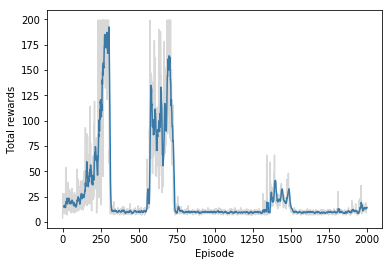

In [31]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'D losses')

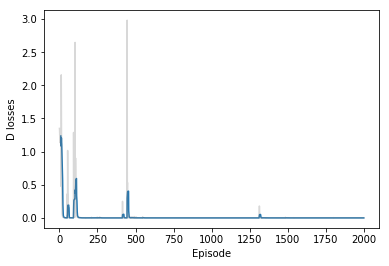

In [32]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'G losses')

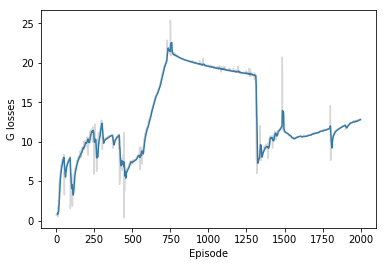

In [33]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'Q losses')

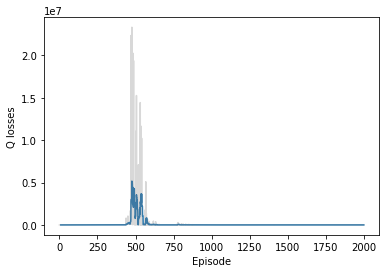

In [34]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

## Testing

Let's checkout how our trained agent plays the game.

In [40]:
test_episodes = 10
test_max_steps = 1000
env.reset()
with tf.Session() as sess:
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    # Save the trained model 
    saver.restore(sess, 'checkpoints/DQAN-cartpole.ckpt')
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            env.render() 
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/DQAN-cartpole.ckpt


In [41]:
env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.